In [1]:
from google.colab import files
uploaded = files.upload()


Saving battery_B0005.csv to battery_B0005.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('battery_B0005.csv')

# Preview
print(df.head())
print(df.info())

   Cycle    Time   Voltage   Current  Temperature  Capacity
0      2   0.000  4.191492 -0.004902    24.330034  1.856487
1      2  16.781  4.190749 -0.001478    24.325993  1.856487
2      2  35.703  3.974871 -2.012528    24.389085  1.856487
3      2  53.781  3.951717 -2.013979    24.544752  1.856487
4      2  71.922  3.934352 -2.011144    24.731385  1.856487
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        50285 non-null  int64  
 1   Time         50285 non-null  float64
 2   Voltage      50285 non-null  float64
 3   Current      50285 non-null  float64
 4   Temperature  50285 non-null  float64
 5   Capacity     50285 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.3 MB
None


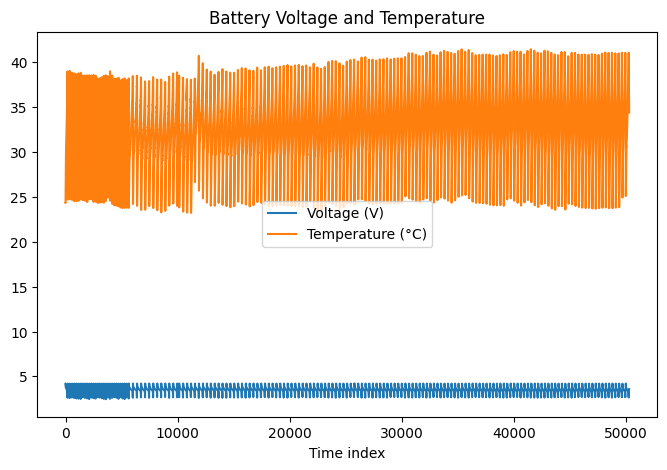

In [4]:
plt.figure(figsize=(8,5))
plt.plot(df['Voltage'], label='Voltage (V)')
plt.plot(df['Temperature'], label='Temperature (°C)')
plt.xlabel('Time index')
plt.legend()
plt.title('Battery Voltage and Temperature')
plt.show()


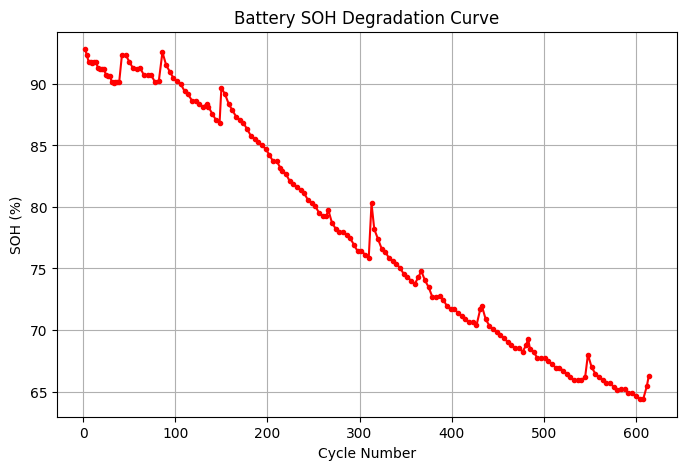

In [5]:
Q_rated = 2.0  # Ah (from NASA dataset)
soh_per_cycle = df.groupby('Cycle')['Capacity'].mean() / Q_rated * 100

plt.figure(figsize=(8,5))
plt.plot(soh_per_cycle.index, soh_per_cycle.values, 'r.-')
plt.xlabel('Cycle Number')
plt.ylabel('SOH (%)')
plt.title('Battery SOH Degradation Curve')
plt.grid(True)
plt.show()


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

features = ['Voltage', 'Current', 'Temperature']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Create sequence data for LSTM
def create_sequences(data, labels, seq_length=50):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = labels[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use capacity or SOH as target
y = df['Capacity'].values
X, Y = create_sequences(X_scaled, y)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define LSTM model
class BatteryLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2):
        super(BatteryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

model = BatteryLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 30
for epoch in range(num_epochs):
    for X_batch, Y_batch in loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")


Epoch 1/30, Loss: 0.031177
Epoch 2/30, Loss: 0.025993
Epoch 3/30, Loss: 0.026409
Epoch 4/30, Loss: 0.038498
Epoch 5/30, Loss: 0.031991
Epoch 6/30, Loss: 0.022731
Epoch 7/30, Loss: 0.015518
Epoch 8/30, Loss: 0.014429
Epoch 9/30, Loss: 0.015164
Epoch 10/30, Loss: 0.017697
Epoch 11/30, Loss: 0.012633
Epoch 12/30, Loss: 0.013008
Epoch 13/30, Loss: 0.008002
Epoch 14/30, Loss: 0.008267
Epoch 15/30, Loss: 0.009148
Epoch 16/30, Loss: 0.007829
Epoch 17/30, Loss: 0.009857
Epoch 18/30, Loss: 0.005736
Epoch 19/30, Loss: 0.008037
Epoch 20/30, Loss: 0.006613
Epoch 21/30, Loss: 0.003472
Epoch 22/30, Loss: 0.003752
Epoch 23/30, Loss: 0.003192
Epoch 24/30, Loss: 0.003890
Epoch 25/30, Loss: 0.003563
Epoch 26/30, Loss: 0.001739
Epoch 27/30, Loss: 0.002033
Epoch 28/30, Loss: 0.001094
Epoch 29/30, Loss: 0.001525
Epoch 30/30, Loss: 0.001437


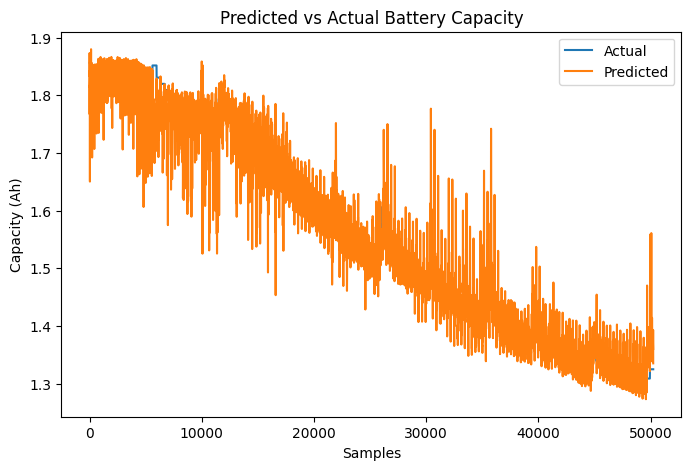

In [9]:
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().numpy()

plt.figure(figsize=(8,5))
plt.plot(Y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Capacity (Ah)')
plt.title('Predicted vs Actual Battery Capacity')
plt.legend()
plt.show()


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
import torch
import os

# Define the directory path
save_dir = '/content/drive/MyDrive/BatteryProject'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Example: Save model to your Drive under "BatteryProject"
torch.save(model.state_dict(), os.path.join(save_dir, 'battery_soh_model.pth'))

print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


In [13]:
!ls /content/drive/MyDrive/BatteryProject


battery_soh_model.pth
